In [1]:
import numpy as np
import pandas as pd
import emcee
import corner
from scipy.optimize import minimize
from multiprocessing import Pool
import time
import matplotlib.pyplot as plt

from fit_just_early_lc import prep_light_curve

from corner_hack import corner_hack
from light_curve_plot import f_t, plot_both_filt

In [2]:
%matplotlib notebook

In [3]:
info_path = "../../forced_lightcurves/sample_lc_v2/"
salt_df = pd.read_csv(info_path + "../../Nobs_cut_salt2_spec_subtype_pec.csv")

# Strong Priors


Broadly speaking, we are building models of the form $f = A t^\alpha$ in order to constrain the rising power-law index of the exploding SN.

## Strongest of priors

Set $\alpha = 2$ as an infinitely strong prior on the early evolution.

In [75]:
# multiplier term for the uncertainties
def lnlike_big_unc(theta, f, t, f_err):
    t_0, a, a_prime,  f_sigma = theta

    pre_exp = np.logical_not(t > t_0)
    model = -np.inf*np.ones_like(f)
    model[pre_exp] = a
    
    time_term = (t[~pre_exp] - t_0)
    model[~pre_exp] = a + a_prime * (time_term)**2
    assert np.all(model > -np.inf),"fewer model values than flux values\n{}\n{}\na{}A'{}alpha{}f_sigma{}".format(model, time_term,a,a_prime,alpha_r,f_sigma)
    
    ln_l = -0.5*np.sum((f - model)**2 / ((f_sigma*f_err)**2)) - np.sum(np.log(f_sigma*f_err)) - 0.5*len(model)*np.log(np.sqrt(2*np.pi))
    return ln_l

def nll_big_unc(theta, flux, time, flux_err):
    return -1*lnlike_big_unc(theta, flux, time, flux_err)

#Define priors on parameters  
def lnprior_big_unc(theta):
    t_0, a, a_prime, f_sigma = theta
    if (a_prime < 0 or 
        f_sigma < 0 or
        t_0 < -100 or
        t_0 > 0 or 
        a < -1e8 or
        a > 1e8):
        return -np.inf
    else:
        return -np.log(a_prime) - np.log(f_sigma)

def lnposterior_big_unc(theta, flux, time, flux_err):
    lnp = lnprior_big_unc(theta)
    if not np.isfinite(lnp):
        return -np.inf
    lnl = lnlike_big_unc(theta, flux, time, flux_err)
    if not np.isfinite(lnl):
        return -np.inf
    return lnl + lnp

In [95]:
def multifcqfid_lnlike_big_unc(theta, f, t, f_err, fcqfid_arr):
    
    n_fcqid = len(np.unique(fcqfid_arr))
    n_filt = len(np.unique(np.unique(fcqfid_arr) % 10))

    if len(theta) != 1 + n_filt + 2*n_fcqid:
        raise RuntimeError('The correct number of parameters were not included')

    ln_l = 0
    for fcqfid_num, fcqfid in enumerate(np.unique(fcqfid_arr)):
        filt = int(fcqfid % 10)

        theta_fcqfid = np.array([theta[0], theta[1 + n_filt + 2*fcqfid_num], 
                                 theta[filt],
                                 theta[2 + n_filt + 2*fcqfid_num]])
        fcqfid_obs = np.where(fcqfid_arr == fcqfid)
        f_fcqfid = f[fcqfid_obs]
        t_fcqfid = t[fcqfid_obs]
        f_err_fcqfid = f_err[fcqfid_obs]
        ln_l += lnlike_big_unc(theta_fcqfid, f_fcqfid, t_fcqfid, f_err_fcqfid)
    
    return ln_l

def multifcqfid_nll_big_unc(theta, f, t, f_err, fcqfid_arr):
    return -1*multifcqfid_lnlike_big_unc(theta, f, t, f_err, fcqfid_arr)

def multifcqfid_lnprior_big_unc(theta, fcqfid_arr):
    
    n_fcqid = len(np.unique(fcqfid_arr))
    n_filt = len(np.unique(np.unique(fcqfid_arr) % 10))

    if len(theta) != 1 + n_filt + 2*n_fcqid:
        raise RuntimeError('The correct number of parameters were not included')

    ln_p = 0
    for fcqfid_num, fcqfid in enumerate(np.unique(fcqfid_arr)):
        filt = int(fcqfid % 10)

        theta_fcqfid = np.array([theta[0], theta[1 + n_filt + 2*fcqfid_num], 
                                 theta[filt],
                                 theta[2 + n_filt + 2*fcqfid_num]])
        ln_p += lnprior_big_unc(theta_fcqfid)
    return ln_p

def multifcqfid_lnposterior_big_unc(theta, f, t, f_err, fcqfid_arr):
    lnp = multifcqfid_lnprior_big_unc(theta, fcqfid_arr)
    if not np.isfinite(lnp):
        return -np.inf
    lnl = multifcqfid_lnlike_big_unc(theta, f, t, f_err, fcqfid_arr)
    if not np.isfinite(lnl):
        return -np.inf
    return lnl + lnp

In [107]:
thin_by = 100
rel_flux_cutoff = 0.4
t_fl = 18

sn = 'ZTF18abauprj'
# sn = 'ZTF18abaxlpi'
# sn = 'ZTF18abdpvnd'

t_max = float(salt_df['t0_g_adopted'][salt_df['name'] == sn].values)
z = float(salt_df['z_adopt'][salt_df['name'] == sn].values)
g_max = float(salt_df['fratio_gmax_2adam'][salt_df['name'] == sn].values)
r_max = float(salt_df['fratio_rmax_2adam'][salt_df['name'] == sn].values)

t_data, f_data, f_unc_data, fcqfid_data = prep_light_curve(info_path+"{}_force_phot.h5".format(sn),
                                                                     t_max=t_max, 
                                                                     z=z,
                                                                     g_max=g_max,
                                                                     r_max=r_max,
                                                                     rel_flux_cutoff=rel_flux_cutoff,
                                                          flux_scale=100)

In [109]:
n_filt = len(np.unique(np.unique(fcqfid_data) % 10))
guess_0 = np.append([-t_fl] + [6e-1]*n_filt,
                    [1,1]*len(np.unique(fcqfid_data)))

ml_res = minimize(multifcqfid_nll_big_unc, guess_0, method='Powell', # Powell method does not need derivatives
              args=(f_data, t_data, f_unc_data, fcqfid_data))
ml_guess = ml_res.x

/Users/adamamiller/miniconda3/envs/emcee3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in log
  del sys.path[0]


In [110]:
ml_guess

array([-18.72771792,   0.67606361,   0.71063819,  -0.0276904 ,
         1.48333138,  -0.04224289,   1.34785961])

In [112]:
#initial position of walkers
ndim = len(ml_guess)
nfac = [10**(-2.5)]*ndim
nwalkers = 100

rand_pos = [1 + nfac*np.random.randn(ndim) for i in range(nwalkers)]
if ml_guess[0] < -5 and ml_guess[-1] < 5:
    pos = ml_guess*rand_pos
else:
    pos = guess_0*rand_pos
    
with Pool(4) as pool:
    burn_sampler = emcee.EnsembleSampler(nwalkers, ndim, 
                                        multifcqfid_lnposterior_big_unc, 
                                        args=(f_data, t_data, 
                                              f_unc_data, fcqfid_data),
                                        pool=pool)
    burn_sampler.run_mcmc(pos, nsteps=5000, 
                        thin_by=1, progress=True)
    flat_burn_chain = burn_sampler.get_chain(flat=True)
    flat_burn_prob = np.argmax(burn_sampler.get_log_prob(flat=True))
    max_prob = flat_burn_chain[flat_burn_prob]
    pos = max_prob*rand_pos

100%|██████████| 5000/5000 [00:50<00:00, 99.35it/s] 


In [113]:
max_prob

array([-18.72587479,   0.67637781,   0.71122808,  -0.02771445,
         1.48308686,  -0.04215393,   1.34398469])

In [114]:
gr_paramsNames=[r'$t_\mathrm{fl}$', 
             r"$A'_g$",  
             r"$A'_r$"]

baseline_list = []
g_fcqfid_idx = 1
r_fcqfid_idx = 1
for fcqfid_num, fcqfid in enumerate(np.unique(fcqfid_data)):
    filt = int(fcqfid % 10)
    if filt == 1:
        baseline_list.append('$a_{{g{}}}$'.format(g_fcqfid_idx))
        baseline_list.append('$\sigma_{{g{}}}$'.format(g_fcqfid_idx))
        g_fcqfid_idx += 1
    elif filt == 2:
        baseline_list.append('$a_{{r{}}}$'.format(r_fcqfid_idx))
        baseline_list.append('$\sigma_{{r{}}}$'.format(r_fcqfid_idx))
        r_fcqfid_idx += 1

gr_paramsNames = gr_paramsNames + baseline_list

<IPython.core.display.Javascript object>


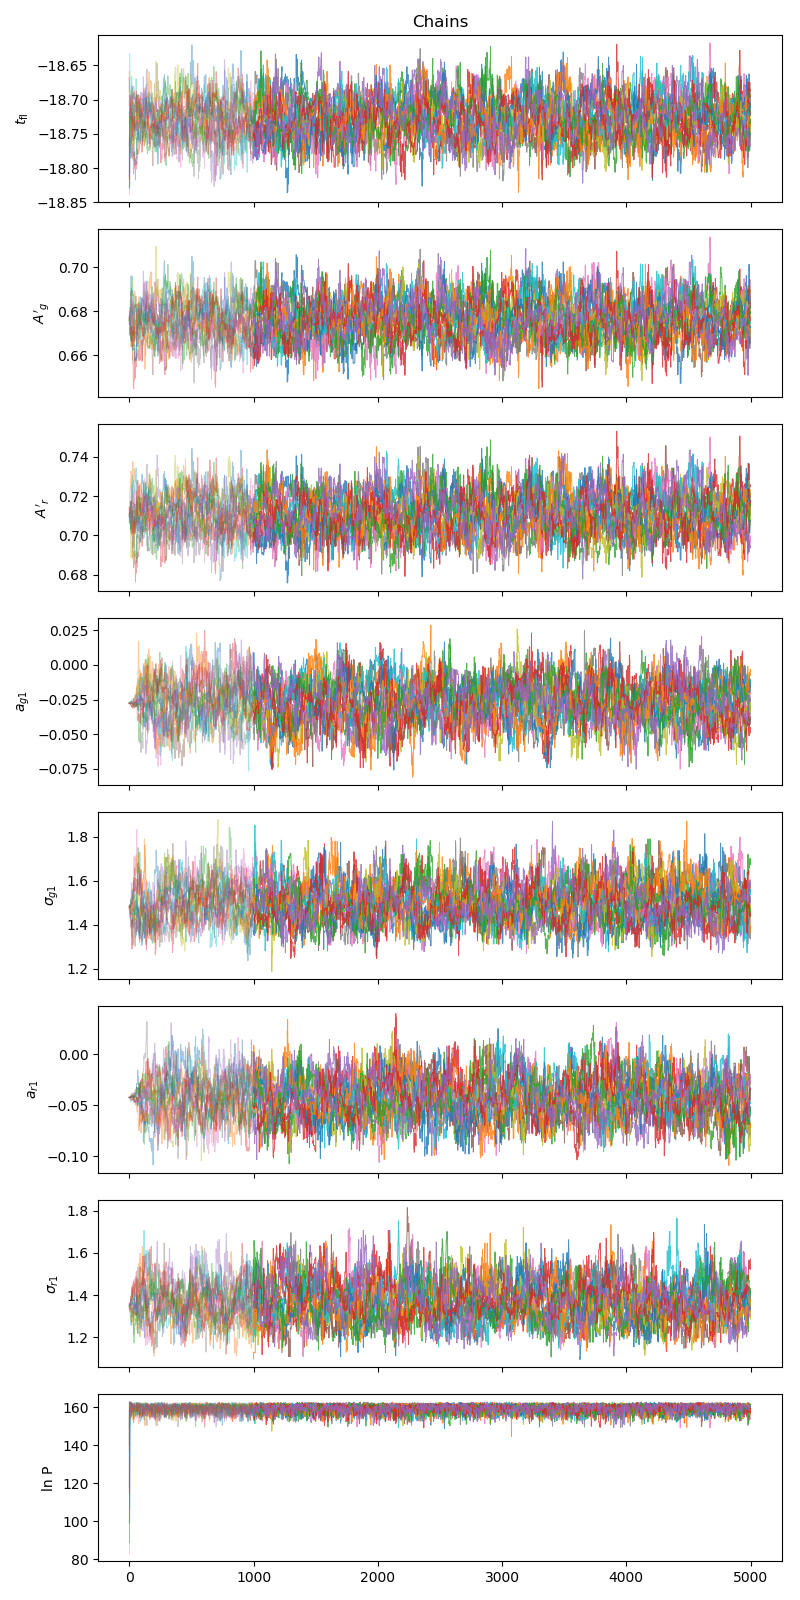

In [115]:
plotChains(burn_sampler, 1000, gr_paramsNames, nplot=15)
plt.tight_layout()

<IPython.core.display.Javascript object>


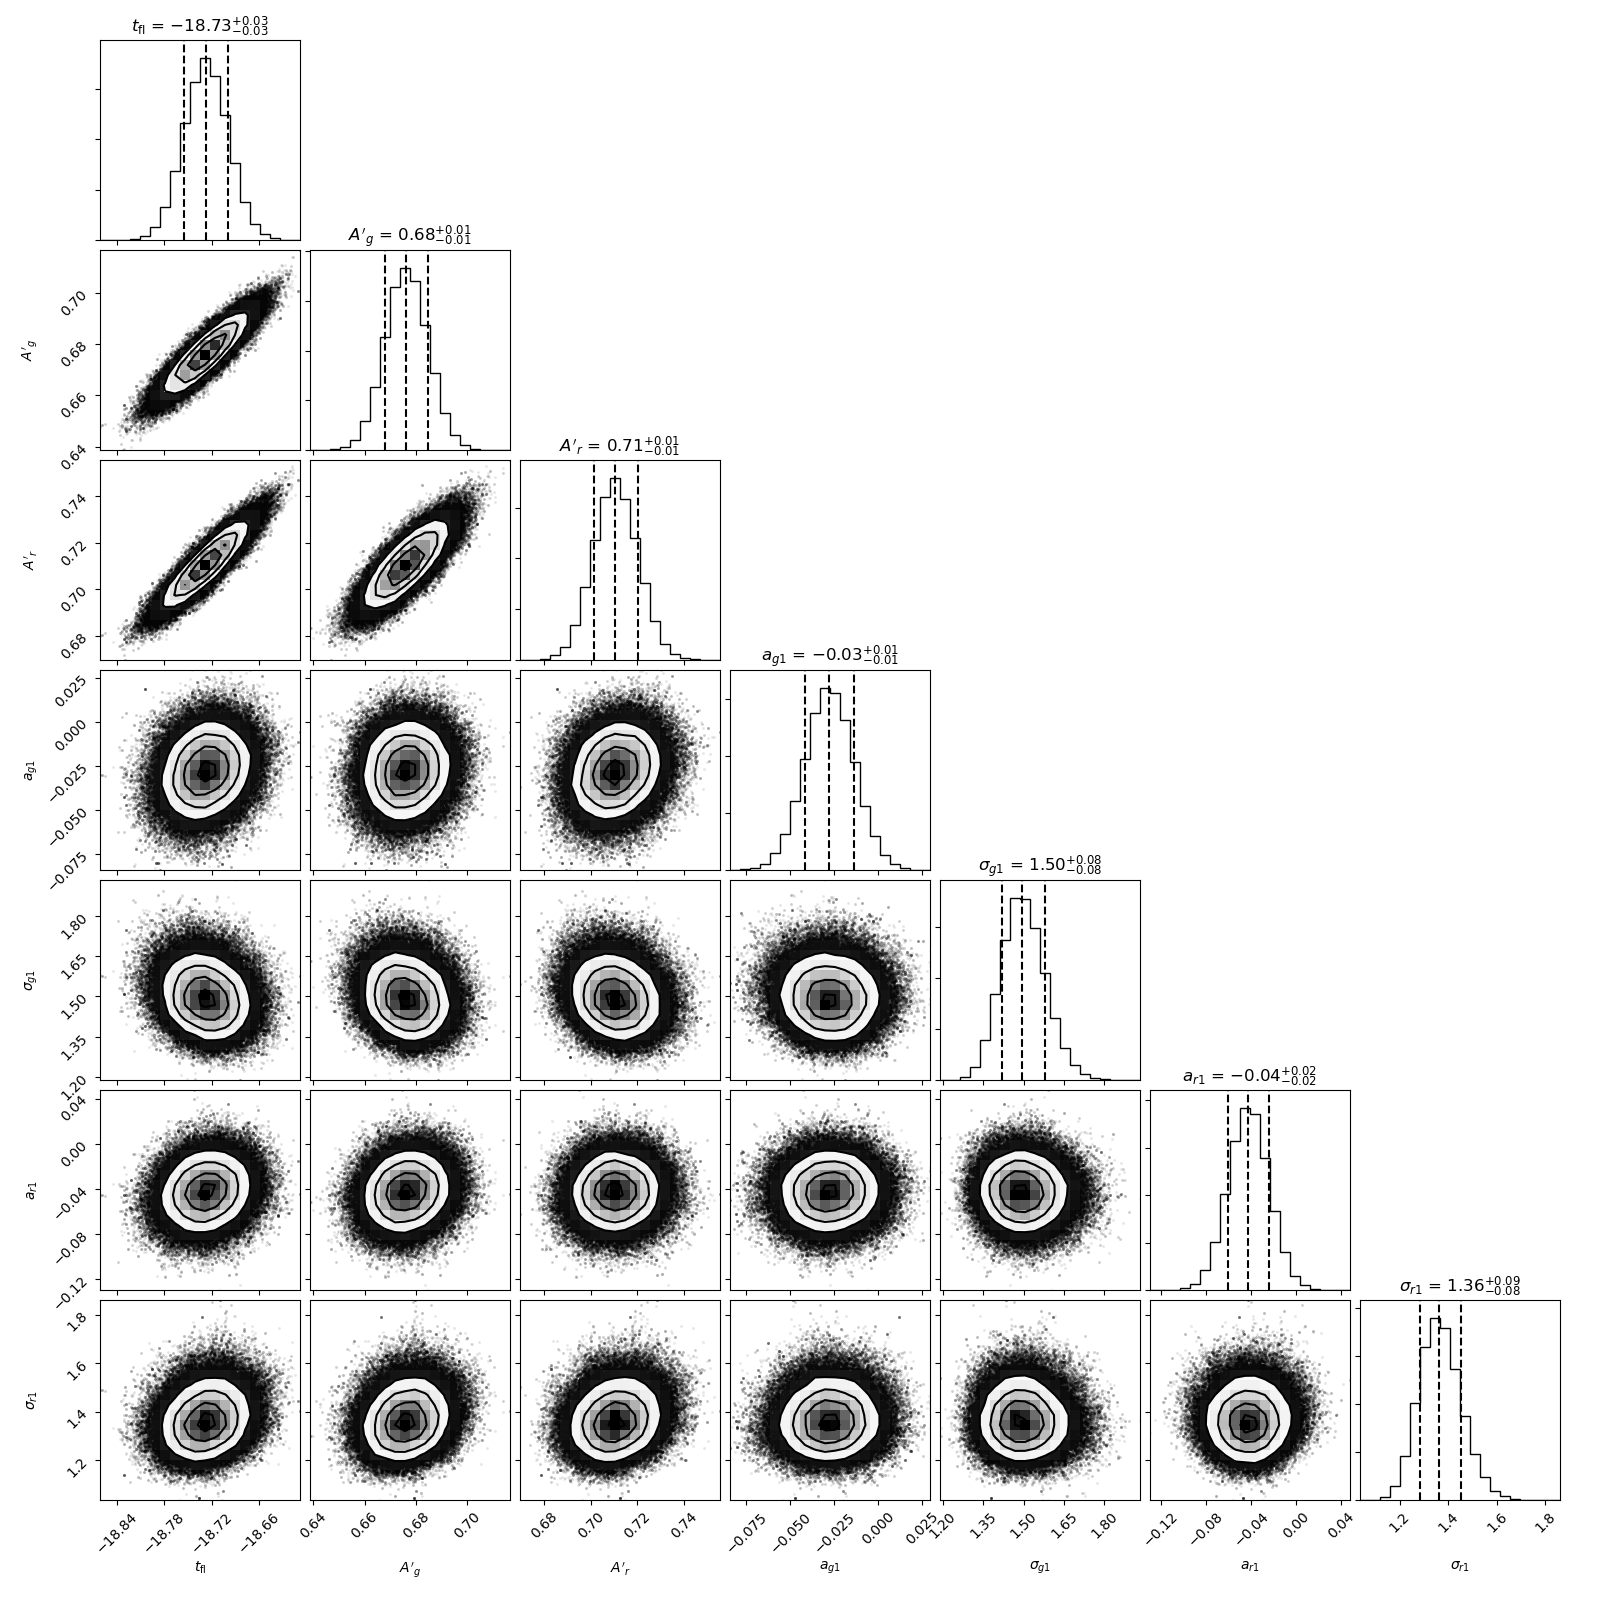

In [116]:
makeCorner(burn_sampler, 1000, gr_paramsNames)

## Prior on rise time

We examine the results when changing the prior to require a rise time of $19.5 \pm 0.5$ days.

In [131]:
# multiplier term for the uncertainties
def lnlike_big_unc(theta, f, t, f_err):
    t_0, a, a_prime, alpha_r, f_sigma = theta

    pre_exp = np.logical_not(t > t_0)
    model = -np.inf*np.ones_like(f)
    model[pre_exp] = a
    
    time_term = (t[~pre_exp] - t_0)
    model[~pre_exp] = a + a_prime * (time_term)**alpha_r * 10.**(-alpha_r)
    assert np.all(model > -np.inf),"fewer model values than flux values\n{}\n{}\na{}A'{}alpha{}f_sigma{}".format(model, time_term,a,a_prime,alpha_r,f_sigma)
    
    ln_l = -0.5*np.sum((f - model)**2 / ((f_sigma*f_err)**2)) - np.sum(np.log(f_sigma*f_err)) - 0.5*len(model)*np.log(np.sqrt(2*np.pi))
    return ln_l

def nll_big_unc(theta, flux, time, flux_err):
    return -1*lnlike_big_unc(theta, flux, time, flux_err)

#Define priors on parameters  
def lnprior_big_unc(theta):
    t_0, a, a_prime, alpha_r, f_sigma = theta
    if (a_prime < 0 or 
        f_sigma < 0 or  
        alpha_r < 0 or
        alpha_r > 1e8 or
        a < -1e8 or
        a > 1e8):
        return -np.inf
    else:
        mean_rise = 19.5
        sigma_rise = 0.2
        return -np.log(a_prime) - np.log(f_sigma) - alpha_r*np.log(10) - np.log(np.sqrt(2*np.pi*sigma_rise**2)) - (t_0 - (-mean_rise))**2/(2*sigma_rise**2)

def lnposterior_big_unc(theta, flux, time, flux_err):
    lnp = lnprior_big_unc(theta)
    if not np.isfinite(lnp):
        return -np.inf
    lnl = lnlike_big_unc(theta, flux, time, flux_err)
    if not np.isfinite(lnl):
        return -np.inf
    return lnl + lnp

In [132]:
def multifcqfid_lnlike_big_unc(theta, f, t, f_err, fcqfid_arr):
    
    n_fcqid = len(np.unique(fcqfid_arr))
    n_filt = len(np.unique(np.unique(fcqfid_arr) % 10))

    if len(theta) != 1 + 2*n_filt + 2*n_fcqid:
        raise RuntimeError('The correct number of parameters were not included')

    ln_l = 0
    for fcqfid_num, fcqfid in enumerate(np.unique(fcqfid_arr)):
        filt = int(fcqfid % 10)

        theta_fcqfid = np.array([theta[0], theta[1 + 2*n_filt + 2*fcqfid_num], 
                                 theta[2*filt-1], theta[2*filt],
                                 theta[2 + 2*n_filt + 2*fcqfid_num]])
        fcqfid_obs = np.where(fcqfid_arr == fcqfid)
        f_fcqfid = f[fcqfid_obs]
        t_fcqfid = t[fcqfid_obs]
        f_err_fcqfid = f_err[fcqfid_obs]
        ln_l += lnlike_big_unc(theta_fcqfid, f_fcqfid, t_fcqfid, f_err_fcqfid)
    
    return ln_l

def multifcqfid_nll_big_unc(theta, f, t, f_err, fcqfid_arr):
    return -1*multifcqfid_lnlike_big_unc(theta, f, t, f_err, fcqfid_arr)

def multifcqfid_lnprior_big_unc(theta, fcqfid_arr):
    
    n_fcqid = len(np.unique(fcqfid_arr))
    n_filt = len(np.unique(np.unique(fcqfid_arr) % 10))

    if len(theta) != 1 + 2*n_filt + 2*n_fcqid:
        raise RuntimeError('The correct number of parameters were not included')

    ln_p = 0
    for fcqfid_num, fcqfid in enumerate(np.unique(fcqfid_arr)):
        filt = int(fcqfid % 10)

        theta_fcqfid = np.array([theta[0], theta[1 + 2*n_filt + 2*fcqfid_num], 
                                 theta[2*filt-1], theta[2*filt],
                                 theta[2 + 2*n_filt + 2*fcqfid_num]])
        ln_p += lnprior_big_unc(theta_fcqfid)
    return ln_p

def multifcqfid_lnposterior_big_unc(theta, f, t, f_err, fcqfid_arr):
    lnp = multifcqfid_lnprior_big_unc(theta, fcqfid_arr)
    if not np.isfinite(lnp):
        return -np.inf
    lnl = multifcqfid_lnlike_big_unc(theta, f, t, f_err, fcqfid_arr)
    if not np.isfinite(lnl):
        return -np.inf
    return lnl + lnp

In [133]:
thin_by = 100
rel_flux_cutoff = 0.4
t_fl = 19.5

sn = 'ZTF18abauprj'
# sn = 'ZTF18abaxlpi'
# sn = 'ZTF18abdpvnd'

t_max = float(salt_df['t0_g_adopted'][salt_df['name'] == sn].values)
z = float(salt_df['z_adopt'][salt_df['name'] == sn].values)
g_max = float(salt_df['fratio_gmax_2adam'][salt_df['name'] == sn].values)
r_max = float(salt_df['fratio_rmax_2adam'][salt_df['name'] == sn].values)

t_data, f_data, f_unc_data, fcqfid_data = prep_light_curve(info_path+"{}_force_phot.h5".format(sn),
                                                                     t_max=t_max, 
                                                                     z=z,
                                                                     g_max=g_max,
                                                                     r_max=r_max,
                                                                     rel_flux_cutoff=rel_flux_cutoff,
                                                          flux_scale=100)

In [134]:
n_filt = len(np.unique(np.unique(fcqfid_data) % 10))
guess_0 = np.append([-t_fl] + [6e1, 2]*n_filt,
                    [1,1]*len(np.unique(fcqfid_data)))

ml_res = minimize(multifcqfid_nll_big_unc, guess_0, method='Powell', # Powell method does not need derivatives
              args=(f_data, t_data, f_unc_data, fcqfid_data))
ml_guess = ml_res.x

/Users/adamamiller/miniconda3/envs/emcee3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in log
  del sys.path[0]


In [135]:
ml_guess

array([-1.92351443e+01,  6.80826540e+01,  2.36237875e+00,  6.73858360e+01,
        2.24278937e+00, -2.80978567e-02,  1.31743452e+00, -5.83959100e-02,
        1.29823669e+00])

In [123]:
#initial position of walkers
ndim = len(ml_guess)
nfac = [10**(-2.5)]*ndim
nwalkers = 100

rand_pos = [1 + nfac*np.random.randn(ndim) for i in range(nwalkers)]
if np.abs(ml_guess[0] + t_fl) < 4:
    pos = ml_guess*rand_pos
else:
    pos = guess_0*rand_pos
    
with Pool(4) as pool:
    burn_sampler = emcee.EnsembleSampler(nwalkers, ndim, 
                                        multifcqfid_lnposterior_big_unc, 
                                        args=(f_data, t_data, 
                                              f_unc_data, fcqfid_data),
                                        pool=pool)
    burn_sampler.run_mcmc(pos, nsteps=5000, 
                        thin_by=1, progress=True)
    flat_burn_chain = burn_sampler.get_chain(flat=True)
    flat_burn_prob = np.argmax(burn_sampler.get_log_prob(flat=True))
    max_prob = flat_burn_chain[flat_burn_prob]
    pos = max_prob*rand_pos

100%|██████████| 5000/5000 [00:54<00:00, 92.19it/s] 


In [127]:
max_prob

array([-1.93193199e+01,  6.73951359e+01,  2.41145076e+00,  6.67542243e+01,
        2.28619017e+00, -2.94090581e-02,  1.33831846e+00, -6.33725266e-02,
        1.28579823e+00])

In [128]:
gr_paramsNames=[r'$t_\mathrm{fl}$', 
             r"$A'_g$", r'$\alpha_{r, g}$', 
             r"$A'_r$", r'$\alpha_{r, r}$']

baseline_list = []
g_fcqfid_idx = 1
r_fcqfid_idx = 1
for fcqfid_num, fcqfid in enumerate(np.unique(fcqfid_data)):
    filt = int(fcqfid % 10)
    if filt == 1:
        baseline_list.append('$a_{{g{}}}$'.format(g_fcqfid_idx))
        baseline_list.append('$\sigma_{{g{}}}$'.format(g_fcqfid_idx))
        g_fcqfid_idx += 1
    elif filt == 2:
        baseline_list.append('$a_{{r{}}}$'.format(r_fcqfid_idx))
        baseline_list.append('$\sigma_{{r{}}}$'.format(r_fcqfid_idx))
        r_fcqfid_idx += 1

gr_paramsNames = gr_paramsNames + baseline_list

<IPython.core.display.Javascript object>


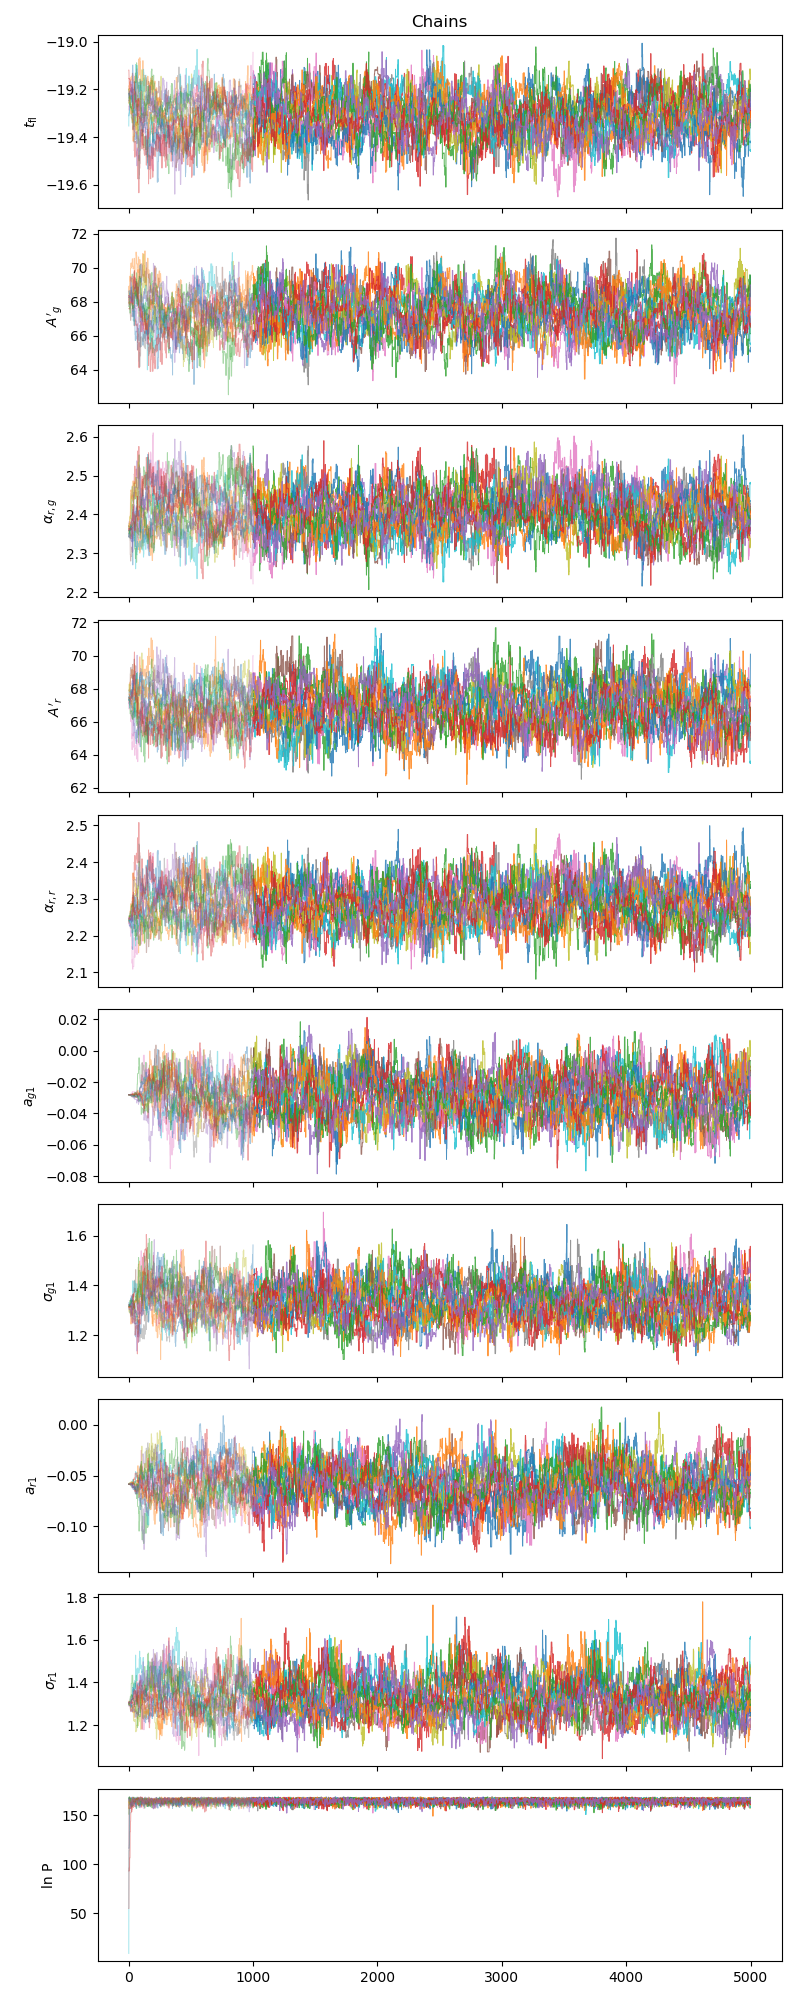

In [129]:
plotChains(burn_sampler, 1000, gr_paramsNames, nplot=15)
plt.tight_layout()

<IPython.core.display.Javascript object>


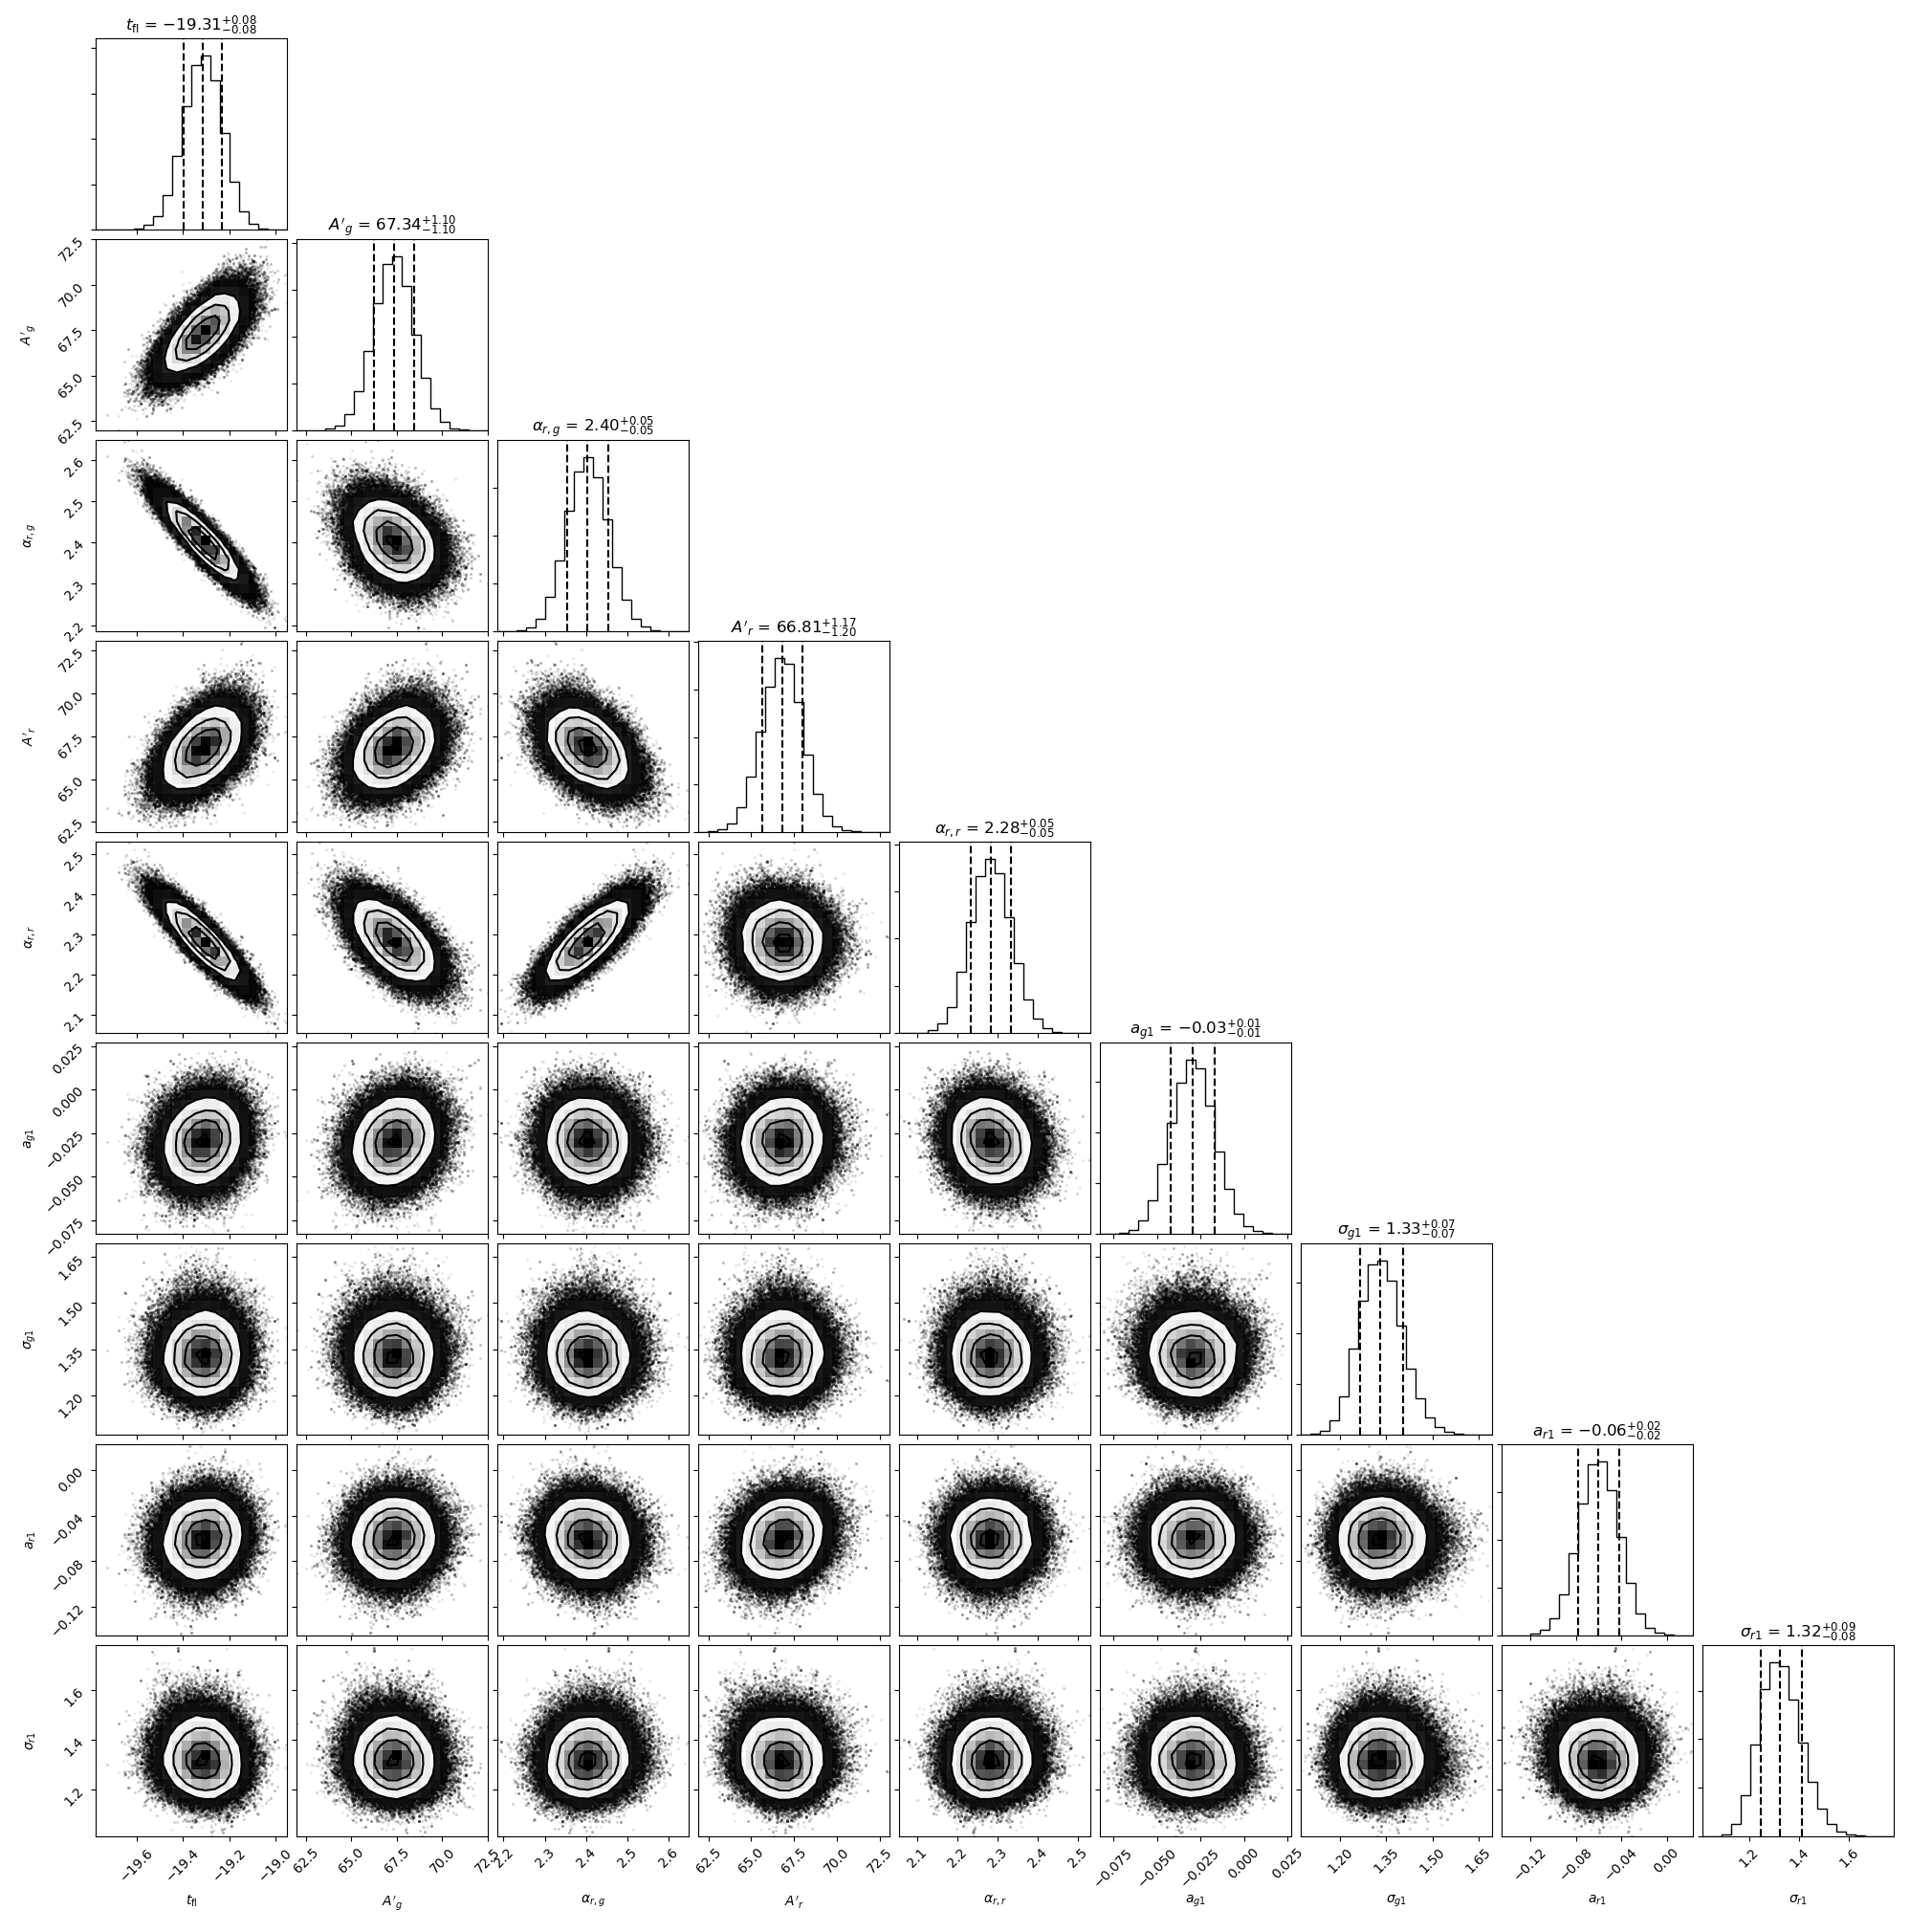

In [130]:
makeCorner(burn_sampler, 1000, gr_paramsNames)

In [20]:
#define funtion to make corner plot
def makeCorner(sampler, nburn, paramsNames, quantiles=[0.16, 0.5, 0.84], truths=[]):
    samples = sampler.get_chain(discard=nburn, flat=True)
    if len(truths) > 0:
        f = corner.corner(samples, labels = paramsNames, quantiles = quantiles, 
                          truths=truths, plot_datapoints=False)
    else:
        f = corner.corner(samples, labels = paramsNames, quantiles = quantiles, 
                          show_titles=True, plot_datapoints=True)
    
#define function to plot walker chains  
def plotChains(sampler, nburn, paramsNames, nplot=nwalkers):
    Nparams = len(paramsNames)
    fig, ax = plt.subplots(Nparams+1,1, figsize = (8,2*(Nparams+1)), sharex = True)
    fig.subplots_adjust(hspace = 0)
    ax[0].set_title('Chains')
    xplot = np.arange(sampler.get_chain().shape[0])

    selected_walkers = np.random.choice(range(sampler.get_chain().shape[1]), nplot, replace=False)
    for i,p in enumerate(paramsNames):
        for w in selected_walkers:
            burn = ax[i].plot(xplot[:nburn], sampler.get_chain()[:nburn,w,i], 
                              alpha = 0.4, lw = 0.7, zorder = 1)
            ax[i].plot(xplot[nburn:], sampler.get_chain(discard=nburn)[:,w,i], 
                       color=burn[0].get_color(), alpha = 0.8, lw = 0.7, zorder = 1)
            
            ax[i].set_ylabel(p)
            if i==Nparams-1:
                ax[i+1].plot(xplot[:nburn], sampler.get_log_prob()[:nburn,w], 
                             color=burn[0].get_color(), alpha = 0.4, lw = 0.7, zorder = 1)
                ax[i+1].plot(xplot[nburn:], sampler.get_log_prob(discard=nburn)[:,w], 
                             color=burn[0].get_color(), alpha = 0.8, lw = 0.7, zorder = 1)
                ax[i+1].set_ylabel('ln P')
            
    return ax